In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import sys
import pylab as pl

In [2]:
sns.set(rc = {'figure.figsize': (9, 6)})

In [3]:
events_data = pd.read_csv('/Users/avyny/Desktop/event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
submissions_data = pd.read_csv('/Users/avyny/Desktop/submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Далее будет преобразование "timestamp" в дату нормального формата. timestamp - это формат времени в секундах, начиная с 1.01.1970

In [5]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data.head(7)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35
5,32811,1434340895,passed,17632,2015-06-15 04:01:35
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01


**Из полного формата даты (с секундами и часами) выбираем только дату**

In [6]:
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Сделать предобработку данных также для submissions_data

In [7]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


~*Считаем количество уникальных пользователей за каждый день*~

In [8]:
events_data.groupby('day').user_id.nunique().head(7)

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
2015-06-20    294
2015-06-21    292
Name: user_id, dtype: int64

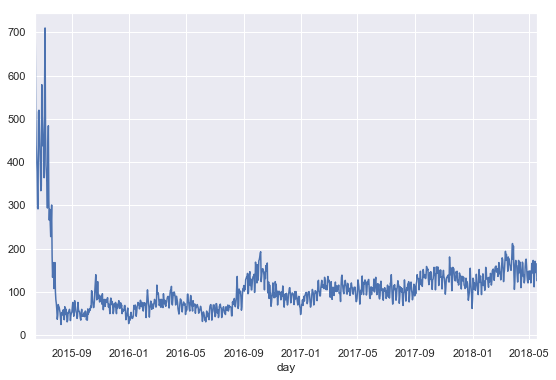

In [9]:
events_data.groupby('day').user_id.nunique().plot()

Сгруппировать данные, что бы можно было видеть по каждому пользователю какое количество степов он прошел, просмотрел и т.д. **в виде сводной таблицы.** + проделаем такое же действие для таблицы "submissions_data"

In [10]:
users_events_data = events_data.pivot_table(index = "user_id", columns = "action", values = "step_id", aggfunc="count", fill_value=0) \
           .reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [11]:
users_scores = submissions_data.pivot_table(index = "user_id", columns = "submission_status", values = "step_id", aggfunc="count", fill_value=0) \
           .reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Далее будем стараться проанализировать данные, чтобы понять какой порог (промежуток во времени между сабмитами) будем брать, чтобы понять будем ли мы относить данного пользователя к категории "ушедшего" с курса. Так как в данных нет информации, указывающей студент ушел с курса или нет, то эту категорию нужно вывести самостоятельно.

**Функция drop_duplicates()** убирает одинаковые комбинации в строчке. Можно сделать фильтр, по каким колонкам применять данную функцию!

In [12]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

**APPLY** применяет функцию к датафрейму
**NP.DIFF** считает разницу между соседними элементами в листе

In [13]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
          98252,    57019]),
       array([1567990]), array([], dtype=int64)], dtype=object)

Чтобы все данные по разницам во времени между решениями сохранить в единый лист, можно применить функцию **NP.CONCATENATE()**

In [14]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))
gap_data.head(8)

0     4843602
1     6899249
2      182484
3       93710
4     2768870
5      171400
6       78712
7    33702812
dtype: int64

**Найдем разницу в днях между заходами на курсы**

In [15]:
gap_data = gap_data / (24 * 60 * 60)
gap_data.head()

0    56.060208
1    79.852419
2     2.112083
3     1.084606
4    32.047106
dtype: float64

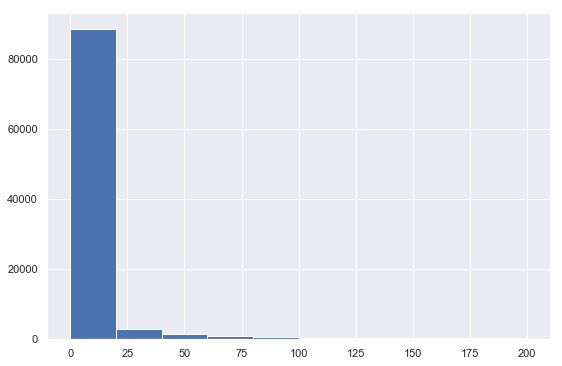

In [16]:
gap_data[gap_data < 200].hist()

**QUANTILE(0.95)** У 95% пользователей разница между заходами на курс составляет не более 59 дней. Подобным образом можно посчитать и другие персентили. Например у 92% пользователей средняя разница между заходами на курс составляет не более 27 дней.

In [17]:
gap_data.quantile(0.92)

27.452338425926108

Далее будем присваивать, если пользователь не заходил 30 дней и у него нет сертификата по курсу, то считать его дропнувшим // 
- **now** - последний timestamp в данных (на 19-05-2018)
- **droup_out** - время в секундах за 1 месяц
- **is_gone_user** - показывает ***"True"*** если пользователь не заходил на платформу более 30 дней, и ***"False"*** - если заходил в курс в течении последнего месяца

In [18]:
users_data = events_data.groupby('user_id', as_index = False) \
    .agg({'timestamp': 'max'}).rename(columns = {'timestamp': 'last_timestamp'})
now = 1526772811
droup_out_threshold = 30 * 24 * 60 * 60
users_data['is_gone_user'] = (now - users_data.last_timestamp) > droup_out_threshold
users_data.head(10)

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
5,8,1481466913,True
6,9,1484999497,True
7,11,1526140625,False
8,14,1436368676,True
9,16,1513162585,True


Далее будем смердживать таблицы users_data и users_scores. По умолчанию в PANDAS мерджатся таблицы с "inner join", т.е. откинет все значения, что есть в одной таблице, но отсутствуют в другой. Поэтому **если важно ничего не потерять, обязательно нужно дописывать аргумент "how = 'outer'"**

In [19]:
users_data = users_data.merge(users_scores, how = 'outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [20]:
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


Также, к полученному результату добавим еще таблицу **"users_events_data"**

In [21]:
users_data = users_data.merge(users_events_data, how= "outer")
users_data.head(10)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
5,8,1481466913,True,9.0,21.0,109,84,37,156
6,9,1484999497,True,0.0,0.0,3,3,0,4
7,11,1526140625,False,0.0,0.0,1,0,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9
9,16,1513162585,True,77.0,106.0,196,196,108,651


 Добавим также в датафрейм инфу о том, сколько уникальных дней каждый пользователь провел на курсе.

In [22]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how = 'outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Всегда важно проверить никого ли мы не потеряли после проведения предобработки данных!! Для этого сверим количество уникальных пользователей.

In [23]:
users_data.user_id.nunique() == events_data.user_id.nunique()

True

Добавим еще одну колонку, которая дает информацию о том, правда ли, что пользователь успешно прошел курс (за успешностью прохождения будем считать, что он набрал более 170 баллов)

In [24]:
users_data['passed_course'] = users_data.passed > 170
users_data.head(10)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False
8,14,1436368676,True,0.0,1.0,4,3,1,9,1,False
9,16,1513162585,True,77.0,106.0,196,196,108,651,21,True


**ЗАДАЧА:** как можно раньше предсказать, что пользователь дропнется с курса.

Для этого для начала <u>посмотрим на медианное значение дней, которые пользователь проводит на ресурсе для решения курса для тех студентов, которые успешно его прошли.</u>

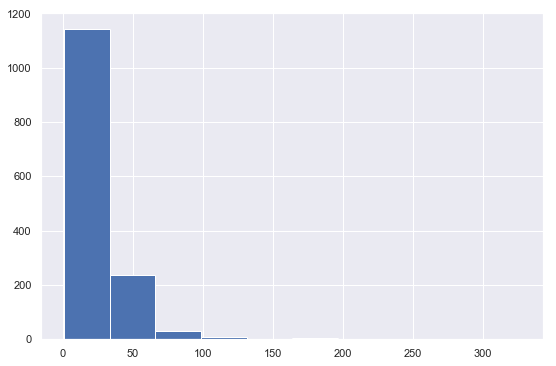

In [25]:
users_data[users_data.passed_course].day.hist()

Далее найдем минимальное значение времени (timestamp) по каждому пользователю (когда он начал курс образно). 

И добавим эту колонку в таблицу users_data

In [26]:
user_min_time = events_data.groupby('user_id', as_index = False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)
users_data = users_data.merge(user_min_time, how = 'outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Далее отберем только те значения из events_data, которые произошли в первые 3 дня после старта курса

In [27]:
events_data = events_data.merge(user_min_time, how = 'outer')
events_data_train = events_data.query("timestamp <= min_timestamp + 3 * 24 * 60* 60")
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


***Далее найдем тот степ, на котором многие студенты <u>бросают курс из-за того, что у них не получается решить практические задачи в нем</u>***

In [28]:
user_max_time = submissions_data.groupby('user_id', as_index = False) \
    .agg({'timestamp': 'max'}) \
    .rename({'timestamp': 'max_timestamp'}, axis=1)

submissions_data = submissions_data.merge(user_max_time, how = "outer")
submissions_data.query("timestamp == max_timestamp").groupby(['step_id', 'submission_status']) \
    .agg({'submission_status' : 'count'}).rename(columns = {'submission_status': 'number_of_cases'}).reset_index() \
    .query("submission_status == 'wrong'").sort_values(['number_of_cases'], ascending = False).head(1)

,step_id,submission_status,number_of_cases
9,31978,wrong,154


Это проверка,где мы проверяем удалось ли нам правильно отфильтровать events_data, чтобы остались только те шаги, которые входят в промежуток только первых 3х дней.

Получилось 4, это возможно, потому что мы считали конкретные дни, а пользователь мог начать поздно ночью проходить курс и соответсвенно + 3 дня в секундах растянутся на 4 дня. Это все нормально.

In [29]:
events_data_train.groupby('user_id').day.nunique().max()

4

Фильтрацию, которую делали для первых 3х дней по events_data нужно также сделать и для submissions_data. 

И проверить все правильно ли отфильтровалось.

In [30]:
submissions_data = submissions_data.merge(user_min_time, how = 'outer')
submissions_data_train = submissions_data.drop(['max_timestamp'], axis=1) \
    .query("timestamp <= min_timestamp + 3 * 24 * 60* 60")
submissions_data_train.groupby('user_id').day.nunique().max()

4

Агрегируем данные, сколько дней каждый пользователь был на степике в первые его 3 дня

In [31]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns = {'day': 'days'})
X.head(8)

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
5,17,1
6,22,3
7,25,1


Далее найдем сколько <u>уникальных степов каждый пользователь попытался решить</u> за первые 3 дня обучения на курсе.

И добавим эти данные в датафрейм Х.

In [32]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns = {'step_id': 'steps_tried'})

X = X.merge(steps_tried, how = 'outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


Добавим также информацию по количеству правильных и неправильных ответов по каждому юзеру

In [33]:
X = X.merge(submissions_data_train.pivot_table(index = "user_id", columns = "submission_status", values = "step_id", aggfunc="count", fill_value=0) \
           .reset_index())
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


Добавим также переменную "correct_ratio" -  это отношение сколько всего правильных ответов дал пользователь по отношению со всеми ответами

In [34]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


 Смерджим также данные, по "action", потому что **некоторые пользователи могли просмотреть степ (action == 'viewed'), но не попытаться его решить**

In [35]:
X = X.merge(events_data_train.pivot_table(index = 'user_id',
                                         columns = 'action',
                                         values = 'step_id',
                                         aggfunc = 'count',
                                         fill_value = 0).reset_index()[['user_id', 'viewed']], how = 'outer')
X = X.fillna(0)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [36]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how = 'outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


!! Перед тем, как пускать эти данные на трейн, **нужно убрать тех пользователей, которые недавно начали курс и еще не успели пройти его.**

In [37]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


*Целевая переменная, которую будем предсказывать - это переменная "passed_course" - прошел ли человек курс или нет исходя из его активностей за первые 3 дня*

И переведем ее в число, потому что деревья обучаются на числовых переменных

In [38]:
y = X.passed_course.map(int)

In [39]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


**Сделаем колонку "user_id", как индекс,** чтобы она не участвовала в трейне модели, но в тоже время мы ее не потеряли, потому что она нам нужна будет, чтобы посмотреть на поведения различных юзеров.

In [40]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis = 1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


**Пробуем применить дерево решений на тестовую часть выборки. И смотрим какие показатели метрик качества мы получили**

***Аргументы:***
- <u>**'min_samples_split'**</u> отвечает за то, какое минимальное количество значений должно находиться в квадрате для сплита (например 100, тогда не просплититься все что меньше 100 в квадрате)
- <u>**'min_samples_leaf'**</u> отвечает за то, какое минимальное количество значений может быть в каждом очередном сплите (удобно, когда не хочешь, чтобы сплит расплитовал на 2 направление, в одном 100 значений, в другом 2. Потому что сплит со значением 2 - это с большой вероятностью какой-то частный случай) 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 35)
clf = tree.DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'],
         'max_depth': range(3, 24, 3),
         'min_samples_split': range(50, 60, 5),
         'min_samples_leaf': range(30, 45, 5)}
searching_tree = GridSearchCV(clf, param_grid = params, cv = 5)
searching_tree.fit(X_train, y_train)
best_tree = searching_tree.best_estimator_
best_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 35)
# clf2 = tree.DecisionTreeClassifier(min_samples_leaf = )
# clf2.fit(X_train, y_train)
# clf2.score(X_test, y_test)
# y_predicted_prob = clf2.predict_proba(X_test)
# y_pred = clf2.predict(X_test)
# from sklearn.metrics import precision_score
# precision_score(y_test, y_pred, average='macro')
# from sklearn.metrics import recall_score
# recall_score(y_test, y_pred, average='macro') 
# from sklearn.metrics import f1_score
# f1_score(y_test, y_pred, average ='macro')

In [43]:
best_tree.score(X_test, y_test)

0.9266123054114158

In [44]:
y_predicted_prob = best_tree.predict_proba(X_test)
y_pred = best_tree.predict(X_test)

from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average='macro')

0.7846464646464646

In [45]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='macro')  

0.5372193360922779

In [46]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average ='macro')

0.5504014543251022

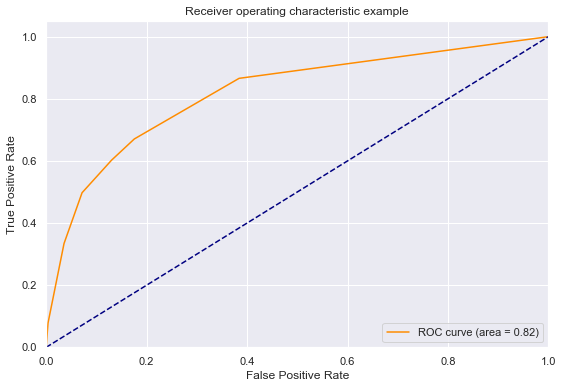

In [47]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**RANDOM FOREST**

Попробуем использовать ансамблевую модель Random Forest.

<u>***СУТЬ МЕТОДА:***</u>
Используется несколько деревьев, которые мы задаем в аргументе "n_estimators". Каждому дереву дается определенный сабсет данных (определенное количество переменных (обычно не все) и определенное количество строк (тоже не все)), таким образом каждое дерево на основании данных, что мы дали просчитывает вероятности наступления зависимого события. Потом все вероятности, полученные в результате каждого дерева усредняются и тот набор параметров, который привел к максимальному усредненному значению вероятности - то и будем считать лучшей комбинацией деревьев.

In [48]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
parameters = {'n_estimators' : [10, 20, 30],
             'max_depth': [2, 5, 7, 10]}
grid_search_cv_clf = GridSearchCV(clf_rf, parameters, cv = 5)
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 30}

In [50]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.9264269829503335

Также можно **посмотреть на важность фичей** из всех данных, что мы давали в random forest.

In [51]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train),
                                       'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending = False)

,features,feature_importances
1,steps_tried,0.274542
2,correct,0.266792
0,days,0.151217
5,viewed,0.149615
4,correct_ratio,0.080405
3,wrong,0.077429
